# **Chap4：循环神经网络RNN**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
import time
import numpy as np
from source.code import ch4
from source.code import utils

2023-05-28 19:59:45.249079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 19:59:45.392470: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 19:59:45.425278: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-28 19:59:46.072669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(device=0,memory=30)

## **4.2 循环神经网络**

### **4.2.1 循环神经网络模型**

前面我们介绍了截断语言模型和 **k-gram 语法模型**，选择截断长度 $\tau$，则 $x_t\sim P(x_t | x_{t-1},\cdots,x_{t-\tau})$，如果我们想要将 $t-\tau$ 之前产生的影响施加给 $x_t$，需要增加 $\tau$，当使用自回归模型时，**模型参数会随之呈指数增长**，因为词表 $\mathcal{V}$ 需要存储 $|\mathcal{V}|^{\tau}$ 个词元数字

因此，不妨考虑**隐状态自回归模型**：
$$
P(x_t | x_{t-1},\cdots,x_1) \approx P(x_t|h_{t-1})
$$

我们用 $h_{t-1}$ 表示**隐状态**（**hidden state**），也称为隐藏变量，它存储了到时间步 $t-1$ 为止的序列信息，通常，我们基于当前输入 $x_t$ 和先前状态 $h_{t-1}$ 来计算时间步 $t$ 的隐状态：
$$
h_t = f(x_t,h_{t-1})
$$

这里需要明确区分两个概念：前面介绍的**全连接神经网络的隐藏层**，和本节所讨论的**隐藏状态**

**(1) 无隐藏状态的神经网络**

考虑单隐藏层的全连接网络，设激活函数为 $\phi$，给定一个批量 $X\in\mathbb{R}^{n\times p}$，其中 $n$ 表示批量大小，特征维度为 $p$，则隐藏层 $H\in\mathbb{R}^{n\times h}$ 为：
$$
H = \phi(XW_{xh} + b_h)
$$

隐藏层权重 $W_{xh}\in\mathbb{R}^{p\times h}$，偏置 $b\in\mathbb{R}^h$，隐藏神经元个数为 $h$，接下来，，将隐藏变量 $H$ 用作输出层的输入，输出层 $O$ 由下式给出：
$$
O = HW_{ho} + b_o
$$

其中，$O\in\mathbb{R}^{n\times o}$ 是输出变量，$W_{ho}\in\mathbb{R}^{ho}\in\mathbb{R}^{h\times o}$ 是输出层权重，$b_o\in\mathbb{R}^o$ 是偏置项，如果是分类问题，还可以用 $\text{softmax}(O)$ 获得概率分布

整个网络计算自输入到输出顺序进行，不存在”**看不见**“的隐藏状态，**隐藏变量** $H$ **也仅指代输出层之前，计算过程中的中间变量而已**，并且模型也**没有包含序列模型的时间结构**

**(2) 使用隐藏状态的循环神经网络**

现在假设在时间步 $t$ 有输入 $X_t \in \mathbb{R}^{n\times p},t = 1,\cdots,T$，$n$ 表示批量大小，即 $n$ 个序列样本，$p$ 表示**特征维度**（词嵌入维度），$X_t$ **的每一行对应于批量样本中时间步** $t$ **处的一个词的特征表示**，接下来，我们用 $H_t\in\mathbb{R}^{n\times h}$ 表示时间步 $t$ 处的隐藏状态，与前面的全连接神经网络不同的是：
* 我们还**需要保存前一个时间步的隐藏状态** $H_{t-1}$
* 引入一个新的权重参数 $W_{hh}\in\mathbb{R}^{h\times h}$

通过它们来描述**如何使用当前时间步，前一个时间步的隐藏变量包含的信息**

具体地说，当前时间步隐藏状态 $H_t$ 由当前时间步的输入 $X_t$ 与前一个时间步的隐藏状态 $H_{t-1}$ 一起计算得出：
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
$$

与全连接网络相比，上式多出了 $H_{t-1}W_{hh}$ 一项，**上式即是对** $h_t = f(x_t,h_{t-1})$ **的一种建模方式**

从相邻时间步的隐藏变量 $H_{t-1},H_t$ 的关系看到，它们**捕获并保留了序列直到当前时间步的历史信息**，这如同**当前时间步下神经网络的状态或记忆**，因此 $H_t$ 被称为隐状态

由于在当前时间步 $t$，**隐状态使用的定义与前一个时间步中使用的定义相同**，因此 $H_t$ 的计算是**循环的**（**recurre**），于是基于循环计算的隐状态神经网络，被人们称为**循环神经网络**（**Recurrent Neural Network**，简称**RNN**），网络中按上式定义的循环计算层称为**循环层**

现在，对于时间步 $t$ 的输出，可以类似于全连接神经网络，用隐状态 $H_t$ 计算：
$$
O_t = H_t W_{ho} + b_o
$$

注意循环神经网络的权重包含：
* **从输入到隐藏状态的变换** $W_{xh}$
* **从上一个隐状态到下一个隐状态的变换** $W_{hh}$
* **从隐状态到输出的变换** $W_{ho}$

需要说明，上述参数不包含时间步下标 $t$，这意味着**即使在不同的时间步，RNN 也总是使用相同的模型参数**，因此，循环神经网络的**参数开销不会随着时间步的增加而增加**

下图展示了 RNN 在三个相邻时间步的计算逻辑，在任意时间步 $t$，隐状态可以被等价视为：
* **拼接当前时间步** $t$ **的输入** $X_t$ **和前一时间步** $t-1$ **的隐状态** $H_{t-1}$
* 将拼接的结果送入一个带有激活函数，输出维度为 $h$ 的全连接网络，得到 $t$ 时刻的隐状态 $H_t$

这可以**通过简单的分块矩阵乘法证明**，在上面展示的计算中，拼接后的全连接层的参数是 $W_{xh},W_{hh}$ 的拼接，**隐藏状态** $H_t$ **会参与当前时间步输出** $O_t$ **和下一隐藏状态** $H_{t+1}$ **的计算**

<img src="../source/Chap4/RNN结构.svg" width=800>

我们来展示一下上述计算过程

In [3]:
X, W_xh = tf.random.normal(shape=(4,2)), tf.random.normal(shape=(2, 4))
H, W_hh = tf.random.normal(shape=(4,4)), tf.random.normal(shape=(4, 4))
# 计算下一个隐状态
H_next = X @ W_xh + H @ W_hh
print(H_next)

2023-05-28 19:59:47.964086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 19:59:48.580924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


tf.Tensor(
[[-3.4621983   2.3219366   0.42681783  7.0344963 ]
 [ 0.8753829  -2.0137646  -0.02432786  0.45059916]
 [-0.2517208  -1.4720496   3.1036294  -0.7099814 ]
 [-0.49829063  0.20061529  1.7727383   5.1443534 ]], shape=(4, 4), dtype=float32)


现在，我们沿着特征轴将 $X_t$，$H_{t-1}$ 拼接，同时将参数 $W_{xh},W_{hh}$ 拼接，重新计算，会发现**结果完全相同**

In [4]:
# 通过拼接重新计算下一个隐状态
H_next = tf.concat([X, H], axis=1) @ tf.concat([W_xh, W_hh], axis=0)
print(H_next)

tf.Tensor(
[[-3.4621983   2.3219364   0.4268179   7.0344963 ]
 [ 0.87538284 -2.0137646  -0.02432787  0.4505992 ]
 [-0.2517209  -1.4720495   3.1036294  -0.7099815 ]
 [-0.4982906   0.20061529  1.7727385   5.1443534 ]], shape=(4, 4), dtype=float32)


下面考虑将循环神经网络应用到语言模型，模型根据过去的和当前的词元预测下一个词元，因此我们**将原始序列移位一个词元作为标签**，假设批量大小为 1，即只有一个样本，其文本序列为"machine"，前面说过，为了简化模型复杂度，我们演示的是**字符级语言模型**，将本文**词元化为字符而不是单词**，下图演示了**字符级语言建模的循环神经网络计算过程**，我们使用当前和先前的字符预测下一个字符

<img src="../source/Chap4/字符级RNN语言建模.svg" width=700>

在训练过程中，我们**对每个时间步的输出层的输出进行softmax操作**，获取预测为每个词元的概率分布 $P(o_t | h_t)$，然后就可以利用**交叉熵损失函数**计算模型预测和标签之间的损失了

### **4.2.2 困惑度 Perplexity**

如何评价一个语言模型生成的质量呢，假如给定历史序列 ”it is raining ...“ 让模型开始续写，三个模型给出三种答案：
* **模型一**："it is raining outside"
  * 模型一最合乎情理，不但补充出正确完整的单词，并且逻辑通顺
* **模型二**："it is raining banana tree"
  * 模型二糟糕很多，因为产生了一个无意义的续写，尽管如此，它已经学会如何拼写单词，续写的单词正确
* **模型三**："it is raining piouwkcjda adoiut"
  * 模型三是训练不足，或训练有误的模型，因为它甚至无法给出正确的单词

一种评估方法是计算序列的似然概率来度量模型的质量，但这会造成一些问题：
* 似然概率依据序列长度变化范围很大，其**数值难以理解**（例如对比分类问题的正确率）
* 较短的序列比较长的序列容易出现，因此二者似然概率的值差异很大，会**导致结果的比较不太公平**

信息论中的**比特**能够帮助我们定义合理的度量
* 如果想要**压缩文本**，我们可以根据当前词元集预测的下一个词元
* **一个更好的语言模型应该能让我们更准确地预测下一个词元**，因此，它应该允许我们在**压缩序列时花费更少的比特**
* 我们可以通过序列中所有 $T$ 个词元的交叉熵损失的均值来衡量：
$$
\frac{1}{T} \sum_{t=1}^{T} -\log{ P(x_t | x_{t-1},\cdots,x_1) }
$$

其中概率 $P$ 由**训练得到的语言模型给出**，$x_t$ 是时间步 $t$ 处序列中的实际词元，上式**让模型在不同长度的文本上的性能具有可比性**，由于历史原因，NLP科学家更喜欢用**困惑度**（**Perplexity**）来衡量，它是上式的指数：
$$
\exp\left( -\frac{1}{T} \sum_{t=1}^{T} \log{ P(x_t | x_{t-1},\cdots,x_1) } \right)
$$

困惑度可以理解是“**下一个词元的实际选择数的调和平均数**”：
* **最好**情况下，模型总是完美预测，**得到标签词元的概率为 1**，此时模型的**困惑度为 1**
* **最坏**情况下，模型**得到标签词元的概率为 0**，此时模型的**困惑度为 正无穷**
* **基准**情况是，模型**对所有次元的概率输出是均匀分布**，假设词表大小为 $|\mathcal{V}|$，则**困惑度就等于词表大小** $|\mathcal{V}|$

根据上面几个例子，就能理解**困惑度表示语言模型在给出正确预测时，有多少个无法确定的词元选择**，最优情况就是只有一个选择，困惑度为 1

### **4.2.3 实现循环神经网络**

**(1) 从零动手实现**

从零实现有助于我们更清楚了解 RNN 每个计算环节发生了什么

首先，我们定义 RNN 模型所需要的几个参数

In [5]:
def get_params(embed_size : int, vocab_size : int, num_hiddens : int):
    # 输入维度 p 等于词嵌入维度 embed_size
    # 输出维度 o 等于词典大小 vocab_size
    num_inputs = embed_size
    num_outputs = vocab_size

    # 正态分布初始化参数
    def normal(shape):
        return tf.random.normal(
            shape=shape, stddev=0.01, mean=0, dtype=tf.float32)

    # 隐藏层参数
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)

    # 输出层参数
    W_ho = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_o = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)

    params = [W_xh, W_hh, b_h, W_ho, b_o]
    return params

在 RNN 运行的初始化时刻，我们需要使用 $H_1$ 来计算输出 $O_1 = P(O_1|H_1)$，而 $H_1$ 的**计算又依赖于**：
$$
H_1 = f(X_1,H_0)
$$

因此，在最开始的时间步 $t=1$，我们**需要有一个初始化的隐藏状态** $H_0$，**才能让计算按照循环的逻辑进行下去**
* 我们这里**返回了一个元组** `tuple`，而不仅仅是一个隐藏状态 $H$，是为了统一函数接口，便于**与后续章节中介绍的模型进行比较**
* 我们可以通过

    ```python
    state = init_rnn_state(batch_size, num_hiddens)
    H, = state
    ```
    来获取该 RNN 模型初始时刻的隐藏状态

In [6]:
# 初始化 RNN 隐藏状态
def init_rnn_state(batch_size : int, num_hiddens : int):
    H = tf.zeros(shape=(batch_size, num_hiddens))
    return (H, )

接下来，我们就可以定义 RNN 的计算逻辑了，注意**除了返回模型的输出外，还需要返回更新后的隐藏状态，以便下一次循环使用，这是循环神经网络有别于其他模型的最显著特征**

In [7]:
def rnn(inputs : tf.Tensor, state : tf.Tensor, params : list):
    """
    Parameters
    ----------
    inputs : tf.Tensor
        输入，形状为 (num_steps, batch_size, embed_size)
    state : tf.Tensor
        隐藏状态，每个的形状为 (batch_size, num_hiddens)
    params : list
        RNN 参数列表，包括 [W_xh, W_hh, b_h, W_ho, b_o]
    
    Returns
    -------
    outputs : tf.Tensor
        输出，形状为 (num_steps * batch_size, vocab_size)
    state : tf.Tensor
        更新后的隐藏状态，每个的形状为 (batch_size, num_hiddens)
    """
    # 获取参数
    W_xh, W_hh, b_h, W_ho, b_o = params
    H, = state

    outputs = []
    # 依次计算每个时间步的输出
    # X 的形状为 (batch_size, embed_size)
    for X in inputs:
        H = tf.tanh(X @ W_xh + H @ W_hh + b_h) # 更新隐藏状态
        Y = H @ W_ho + b_o # 输出，形状为 (batch_size, vocab_size)
        Y = tf.nn.softmax(Y, axis=1) # 得到概率分布
        outputs.append(Y)

    # 返回输出，最后一个时间步的隐藏状态
    return tf.concat(outputs, axis=0), (H, )

拥有了上述所有基本函数后，我们可以创建一个类来包装所有的函数，存储模型所需要的参数，并执行推理逻辑
* 注意，`__call__` 方法会返回两个变量
  * 一个是模型的输出 `output`
  * 一个是经过计算，更新后的隐藏状态 `state`

In [8]:
class RNNBlockScratch:
    def __init__(self, embed_size, vocab_size, num_hiddens, init_state, rnn_func, get_params):
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.init_state = init_state
        self.forward = rnn_func

        # 初始化模型参数
        self.trainable_variables = get_params(embed_size, vocab_size, num_hiddens)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)

    def __call__(self, X : tf.Tensor, state : tf.Tensor):
        """
        X : tf.Tensor
            输入，形状为 (batch_size, num_steps)
        state : tf.Tensor
            隐藏状态
        """
        X = tf.transpose(X) # 将形状变为 (num_steps, batch_size)
        X = self.embedding(X) # 词嵌入，形状为 (num_steps, batch_size, embed_size)
        return self.forward(X, state, self.trainable_variables)

    # 获取初始时刻的隐藏状态
    def begin_state(self, batch_size : int, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

我们生成一些随机数据，检查模型是否能够正确计算

In [9]:
# 输入形状 (batch_size, num_steps)
batch_size, num_steps = 2, 5
X = tf.reshape(tf.range(batch_size*num_steps), (batch_size, num_steps))

# 嵌入维度 embed_size
embed_size = 8
# 词表大小 vocab_size
vocab_size = 28

# 创建模型
num_hiddens = 16
model = RNNBlockScratch(
    embed_size, vocab_size, num_hiddens, 
    init_state=init_rnn_state, rnn_func=rnn, get_params=get_params
)

In [10]:
# 获取初始隐藏状态
state = model.begin_state(X.shape[0])
print("初始时隐藏状态数量：", len(state))
print("初始时隐藏状态形状：", state[0].shape)

Y, new_state = model(X, state)

# 查看输出形状
print("输出形状：", Y.shape)
print("隐藏状态数量：", len(new_state))
print("隐藏状态形状：", new_state[0].shape)

初始时隐藏状态数量： 1
初始时隐藏状态形状： (2, 16)
输出形状： (10, 28)
隐藏状态数量： 1
隐藏状态形状： (2, 16)


从上面可以看待：
* **输出的形状是** `(num_steps * batch_size, vocab_size)`
* 隐藏状态的形状保持不变，即 `(batch_size, num_hiddens)`

最后，我们来考虑**模型的预测问题**：
* 模型需要接收先前的文本序列 `prefix`，然后生成 `prefix` 之后的字符
* 在循环遍历prefix中的开始字符时，我们**不断地将隐状态传递到下一个时间步，但是不生成任何输出**，该阶段称为**预热**（**Warm Up**），目的在于让模型自我更新（**更新隐藏状态**），**让隐藏状态捕获历史序列的信息**
* 预热结束后，**隐状态的值通常比刚开始的初始值更适合预测**，从而**预测字符并输出**它们

In [11]:
def chinese_text_predict(prefix, num_preds, model, vocab, token : str="char"):
    """
    ### 通过前缀 prefix 来预测后续 num_preds 个字符

    Parameters
    ----------
    prefix : str
        前缀字符，即历史文本序列
    num_preds : int
        预测字符个数
    model : Any
        训练好的模型
    vocab : Vocab
        词表
    """
    # 如果词元是单词，先对prefix进行分词
    if token == "word":
        prefix = list(jieba.cut(prefix))

    state = model.begin_state(batch_size=1,dtype=tf.float32)
    # 初始化输出为前缀的第一个字符
    output = [vocab[prefix[0]]]

    # 对输入做变换的预处理函数
    # 获取 output 的最后一个字符，作为下一次预测的输入
    # 相当于获取 X_t
    def get_input():
        return tf.reshape(tf.constant([output[-1]]), (1, 1))

    # 预热期，先将前缀字符的输出作为输入
    for y in prefix[1:]:
        # 不做预测，只更新隐藏状态
        _, state = model(get_input(), state)
        output.append(vocab[y])
    
    # 预测期，将前一时间步的输出作为当前时间步的输入
    # 让模型开始滚动预测
    for _ in range(num_preds):
        y, state = model(get_input(), state)
        output.append(int(y.numpy().argmax(axis=1).reshape(1)))
    
    # 将输出索引转换为字符串
    output_str = ''.join([vocab.idx_to_token[i] for i in output])
    return output_str

现在我们导入我们的词表，测试函数工作是否正常，来看看未经过训练的模型会生成什么内容

In [12]:
# 导入词表
data_loeader = ch4.SeqDataLoader(
    file="../source/data/text/wiki_zh_2019/wiki_zh_2019.txt",token="char")
vocab = data_loeader.vocab

100%|██████████| 10000/10000 [00:01<00:00, 5091.98it/s]


In [13]:
# 创建模型
model = ch4.RNNBlockScratch(
    embed_size=64, vocab_size=len(vocab), num_hiddens=256,
    init_state=init_rnn_state, rnn_func=rnn, get_params=get_params)

In [14]:
ch4.chinese_text_predict("今天天气真好，我想", 10, model, vocab)

'今天天气真好，我想破辽友聆勒籴爸语惘涵'

由于我们**还没有训练网络，它会生成荒谬胡乱的预测结果**

**(2) 使用 API 实现**

`Tensorflow` 的高级API提供了循环神经网络的实现，我们构造一个具有**256个隐藏单元**的**单隐藏层**的循环神经网络层rnn_layer
* 事实上，目前我们还没有讨论 **RNN 中多隐藏层层循环神经网络的意义**，这会在后续章节介绍
* 当层数为 1 时，计算逻辑与我们上面介绍的相同
* 在 `Tensorflow` 中，所有的 RNN 模型都需要用 `tf.keras.layers.RNN` 包装
  * `time_major` 参数，确定输出维度排列是 `(num_steps, batch_size, output_size)`，
    * 否则，批量会成为第一个维度，即输出形状为 `(batch_size, num_steps, output_size)`
  * `return_sequences` 控制是否返回输出序列
  * `return_state` 控制是否返回隐藏状态

In [15]:
num_hiddens = 256
# 先定义 RNN 块，再定义 RNN 层
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(
    rnn_cell, time_major=True, return_sequences=True, return_state=True)

In [16]:
batch_size = 32
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

生成随机的输入数据测试模型的输出结果
* 特别注意，`rnn_layer` 的**输出不涉及我们文本预测任务输出层的计算**，它**返回的是每个时间步的隐藏状态**
  * 这些**隐藏状态可以用来作为后续输出层的输入**，就像我们上面设计的 $O_t = H_tW_{ho} + b_o$ 一样

In [17]:
num_steps, vocab_size = 10, 28
X = tf.random.uniform(shape=(num_steps, batch_size, vocab_size))
Y, state_new = rnn_layer(X, state)

# 打印输出形状
print("输出形状：", Y.shape)
print("隐藏状态形状：", state_new.shape)

输出形状： (10, 32, 256)
隐藏状态形状： (32, 256)


因此，`rnn_layer` 输出**最后一个时间步就是模型最后更新得到的隐藏状态**

In [18]:
last_timestep_output = Y[-1]
# 判断最后一个时间步的输出和隐藏状态是否相等
np.all(last_timestep_output.numpy() == state_new.numpy())

True

最后，我们可以继承 `tf.keras.layers.Layer`，定义 RNN 模型

In [19]:
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, embed_size : int, vocab_size : int, 
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        # 定义嵌入层
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        # 定义输出层
        self.dense = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax()
    
    def call(self, inputs : tf.Tensor, state : tf.Tensor, *args, **kwargs):
        """
        inputs : tf.Tensor
            输入，形状为 (batch_size, num_steps)
        """
        # 交换输入的时间步和批量维度，然后进行词嵌入
        X = self.embedding(tf.transpose(inputs))
        
        # RNN 会返回两个输出 Y 和 state
        # *state 会将 RNN 返回的 state 包装为一个列表
        # 这让函数的返回与我们之前接口保持统一
        Y, *state = self.rnn(X, state) # 输出 Y 形状为 (num_steps, batch_size, num_hiddens)

        # 将输出形状变换为 (num_steps * batch_size, num_hiddens)
        Y = tf.reshape(Y, (-1, Y.shape[-1]))
        
        # 计算输出
        output = self.dense(Y) # 形状为 (num_steps * batch_size, vocab_size)
        output = self.softmax(output)
        
        return output, state

    # 获取初始隐藏状态
    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

我们对上面的 `*state` 运算做简单说明，在刚才的例子中，如果我们**更换语句**：
```python
Y, state_new = rnn_layer(X, state)
```
为：
```python
Y, *state_new = rnn_layer(X, state)
```

In [20]:
Y, *state_new = rnn_layer(X, state)

# 打印输出形状
print("输出形状：", Y.shape)
print("隐藏状态类型：", type(state_new))
print("隐藏状态数量：", len(state_new))
print("隐藏状态形状：", state_new[0].shape)

输出形状： (10, 32, 256)
隐藏状态类型： <class 'list'>
隐藏状态数量： 1
隐藏状态形状： (32, 256)


对比原本的输出，此时 `state_new` 被包装到了一个列表中，这就与我们在**从零开始实现**时定义的接口相同了
* 我们可以测试一下模型的接口是否工作正常

In [21]:
def create_rnn_model(num_hiddens : int, embed_size : int, vocab_size : int):
    """
    创建 RNN 模型
    """
    rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,kernel_initializer="glorot_uniform")
    rnn_layer = tf.keras.layers.RNN(
        rnn_cell, time_major=True, return_sequences=True, return_state=True)
    model = RNNModel(rnn_layer, embed_size, vocab_size)

    return model

In [22]:
# 创建模型
model = ch4.create_rnn_model(num_hiddens=256, embed_size=64, vocab_size=len(vocab))

In [23]:
ch4.chinese_text_predict("今天天气真好，我想", 10, model, vocab)

'今天天气真好，我想墡W己菻胱奠冒℃龛ो'

### **4.2.4 模型训练**

在训练 RNN 时，我们可能会遇到**因矩阵乘法导致的数值不稳定问题**：
* 对于长度为 $T$ 的序列，我们在迭代中计算这 $T$ 个时间步上的梯度
  $$
  Y_T = f(H_T) = f(g(X_T,H_{T-1})) = f(g(X_T,g(X_{T-1},H_{T-2}))) = \cdots
  $$
* 根据**链式法则**，在**反向传播过程中产生长度为** $\mathcal{O}(T)$ **的矩阵乘法**
* 在时间长度 $T$ 较大时，使用该梯度更新参数会**导致数值不稳定**，梯度消失和梯度爆炸都有可能出现

因此，循环神经网络模型往往**需要额外的方式来支持稳定训练**，在梯度下降的更新过程中，假设一次迭代我们将 $\boldsymbol{\theta}$ 更新为 $\boldsymbol{\theta} - \eta \boldsymbol{g}$，如果进一步假设优化函数 $f$ 性质良好，例如**Lipchitz连续**，则：
$$
|f(\boldsymbol{\theta}) - f(\boldsymbol{\theta} - \eta\boldsymbol{g}) | \leq L\eta \|\boldsymbol{g}\|
$$

这意味着我们**不会观察到超过** $L\eta\|\boldsymbol{g}\|$ **的变化**，这既是坏事，也是好事：
* 坏事在于**它限制了模型更新的速度**
* 好处在于**它减缓了模型变糟的程度**，尤其是当模型朝着错误的方向前进时

有时**梯度可能很大，从而优化算法可能无法收敛**：
* 可以通过**降低学习率**来解决这个问题，但如果 $\eta \to 0$，在**通常大部分情况下，又会导致模型更新缓慢**，这种改进显然不合理
* 另一种主流的方法是**限制梯度的范数**，将 $\boldsymbol{g}$ 投影到给定半径的球中，进行**梯度裁剪**

给定**超球体的半径** $r$，**梯度裁剪执行如下操作**：
$$
\boldsymbol{g}\leftarrow \min\left( 1, \frac{r}{\|\boldsymbol{g} \|} \right)\boldsymbol{g}
$$

* 经过变换，**梯度范数永远不会超过** $r$
* 更新后的梯度完全与 $\boldsymbol{g}$ **保持在同一方向**
* 由于我们使用的是**批量随机梯度下降**，梯度裁剪还**限制了任何小批量数据对参数向量的影响**，因此模型训练不会一个随机的糟糕的批量而崩溃，增强了稳定性

**梯度裁剪提供了一个快速修复梯度爆炸的方法**，虽然它并不能完全解决问题，但它是众多有效的技术之一

In [24]:
def grad_clipping(grads : list, radius : float):
    """
    ### 梯度裁剪

    Parameters
    ----------
    grads : list
        每组参数的梯度组成的列表
    radius : float
        裁剪半径
    """
    radius = tf.constant(radius,dtype=tf.float32)
    new_grads = []

    # 依次取出每组参数的梯度，将梯度转换为张量
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grads.append(tf.convert_to_tensor(grad))
        else:
            new_grads.append(grad)
    
    # 计算梯度范数
    norm = tf.math.sqrt(sum([(tf.reduce_sum(grad ** 2)).numpy() for grad in new_grads]))
    norm = tf.cast(norm, dtype=tf.float32)

    # 范数超过半径，进行裁剪
    if tf.greater(norm, radius):
        for i, grad in enumerate(new_grads):
            new_grads[i] = grad * radius / norm
    
    return new_grads

接下来，我们就可以开始定义模型的训练函数了，它与我们之前章节定义的训练函数有四个不同之处：
* 序列数据的不同采样方法（**随机采样策略**和**顺序分区策略**）将导致**隐状态初始化的差异**
* 我们在**更新模型参数之前裁剪梯度**
* 我们用**困惑度** Perplexity 来评价模型
* 我们**在训练过程中就统计每次迭代损失函数的值**，以便于最后计算困惑度

我们还在训练过程中**记录了模型处理文本词元的速度**

In [25]:
def train_text_generation(model, train_iter : ch4.SeqDataLoader, use_random_iter : bool=True, 
                          Epochs : int=10, lr : float=0.1, verbose : int=1):
    # 设定优化器和损失函数
    # SparseCategoricalCrossentropy 不需要将标签转换为 one-hot 向量
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    animator = utils.Animator(xlabel='epoch', ylabel='perplexity', 
                              legend=("perplexity",), xlim=[1, Epochs])

    # 存储每个迭代周期的损失和样本量
    loss_batch, samples_batch = 0, 0
    # 记录单词处理速度
    speeds = []

    for epoch in range(Epochs):
        state, start = None, time.time()
        for x_batch, y_batch in train_iter:
            # 如果是随机采样，每次迭代都随机初始化隐藏状态
            if state is None or use_random_iter:
                # 初始化隐藏状态
                state = model.begin_state(batch_size=x_batch.shape[0], dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                y_hat, state = model(x_batch, state)
                y = tf.reshape(tf.transpose(y_batch), (-1,))
                loss = loss_func(y, y_hat)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            grads = grad_clipping(grads, 1)
            optimizer.apply_gradients(zip(grads, weights))

            # 将该批量的损失函数值加到总损失函数值上
            loss_batch += loss.numpy() * tf.size(y).numpy()
            samples_batch += tf.size(y).numpy()
        
        end = time.time()
        speeds.append(samples_batch / (end - start))
        
        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 计算困惑度
            ppl = tf.math.exp(loss_batch / samples_batch).numpy()
            animator.add(epoch + 1, [ppl])

    print(f"平均 {np.mean(speeds):.1f} 词元/秒")
    return model

我们使用余华的几个作品集作为文本训练集做演示，导入**词表和训练数据集**，开始训练模型，我们**设置每个子序列的文本长度为 32**

In [26]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="../source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=32, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab

# 计算语料库大小
if isinstance(train_iter.corpus[0], list):
    corpus_size = sum(len(c) for c in train_iter.corpus)
else:
    corpus_size = len(train_iter.corpus)
print("语料库大小：", corpus_size)

# 实例化模型
model = ch4.create_rnn_model(num_hiddens=512, embed_size=64, vocab_size=len(vocab))

100%|██████████| 31692/31692 [00:00<00:00, 303898.66it/s]


语料库大小： 864985


In [27]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想基负崇妇艺舞构（瞬趣
太阳从西边出来了，条尾凉冥澡裆肚愈停咐


未训练的模型会进行胡乱预测，甚至**无法给出正确的词汇的语句表达**

平均 50159.3 词元/秒


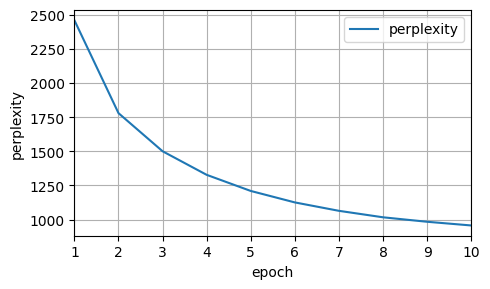

In [28]:
model = ch4.train_text_generation(model,train_iter=train_iter,use_random_iter=True,Epochs=10,verbose=1)

现在，我们来测试一下**训练后模型的预测效果**

In [30]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想到我们，他们的一个，
太阳从西边出来了，他们的一个，他们的一


可以看到效果并不好，**中文词元众多，且词元组成更复杂多样，仅依靠这个简单的 RNN 模型实现正确预测非常困难**，模型的困惑度很高
* 但相比没有训练过的模型，**模型预测的词汇至少是正确的**
* **但可惜词汇单一且重复，不具有任何实际含义**

---

### **练习**

1. 接下来我们**在英文文本数据集上**测试 RNN 模型
   1. 利用小说文本 `../source/data/text/time_traveller.txt`，从 `../source/code/ch4_hw,py` 创建 `TimeTravellerLoader`，请使用**按字母分词**方案，语料库的大小是多少？超参数设计如下：
      1. `batch_size = 64` 或者 `batch_size = 128`
      2. `num_steps = 32`
   2. 针对英文文本，设计文本预测函数 `english_text_predict()`，并将它写入 `../source/code/ch4_hw.py` 以便后续章节使用
   3. 创建一个 RNN 模型，设定合适的模型参数 `num_hiddens`, `embed_size`，学习率设定为 `lr = 1`，迭代次数 `Epochs` 设定100以上
   4. 给定前缀 `prefix = "time traveller "`，测试模型向后预测的结果，你也可以测试其他前缀
      1. 模型的输出效果如何？它能正确拼写单词吗？模型的续写存在什么问题？
   5. 尝试重新定义训练函数，去除掉**梯度裁剪**，重新创建一个模型并训练，观察训练结果，你会得到什么结论？
   6. 如果将词元化方案从**字母词元化**更改为**单词词元化**，重新创建模型并训练，模型的效果如何？
      1. **单词词元化的词表大小**是多少？
      2. 你觉得用单词词元化训练模型面临的困难有哪些？**如何才能保证比较好的模型效果，降低困惑度**

----